In [2]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# setup quandl api
quandl.ApiConfig.api_key = '' # insert API key here

In [4]:
# get the market data for specific securities
#selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
selected = ['KO', 'PFE', 'AAPL', 'WTI', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                       qopts = { 'columns' : ['date', 'ticker', 'adj_close'] },
                       date = { 'gte' : '2014-1-1', 'lte' : '2017-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2017-12-29,WTI,3.31
1,2017-12-28,WTI,3.33
2,2017-12-27,WTI,3.32
3,2017-12-26,WTI,3.30
4,2017-12-22,WTI,3.04


In [5]:
# clean the data, with date as index and with the tickers as columns
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.head()

adj_close                                         
ticker           AAPL         KO        PFE    TSLA        WTI
date                                                          
2014-01-02  73.523423  36.092891  26.382522  150.10  14.826754
2014-01-03  71.908415  35.915356  26.434490  149.56  14.594025
2014-01-06  72.300536  35.746698  26.460474  147.00  14.390388
2014-01-07  71.783135  35.853219  26.625040  149.36  14.739481
2014-01-08  72.238063  35.453765  26.806929  151.28  14.215841

In [6]:
# calculate daily and  annual returns
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 251

In [7]:
# get daily and annual covariance of the returns
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 251

In [8]:
returns_annual.head()

           ticker
adj_close  AAPL      0.233693
           KO        0.068806
           PFE       0.093211
           TSLA      0.264111
           WTI      -0.123323
dtype: float64

In [9]:
# initialize returns, volatility and stock weights array
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

In [10]:
# set the number for random portfolio generation
num_assets = len(selected)
num_portfolios = 50000
np.random.seed(999)

In [72]:
# generate the portfolios
for p in range(num_portfolios):
    weights = np.random.random(num_assets)
    
    weights /= np.sum(weights)
    #print(weights)
    if np.sum(weights) > 1.01:
        print("fail")
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    # sharpe ratio with a risk free return rate of 0
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [12]:
# a dict containing all the returns and risks for the portfolios
portfolios = {'Returns' : port_returns, 'Volatility' : port_volatility, 'Sharpe Ratio' : sharpe_ratio}
for idx, symbol in enumerate(selected):
    portfolios[symbol + ' Weight'] = [w[idx] for w in stock_weights]

In [13]:
# create a dataframe containing our portfolio dict
df = pd.DataFrame(portfolios)
col_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [symbol + ' Weight' for symbol in selected]
df = df[col_order]
df.head()

,Returns,Volatility,Sharpe Ratio,KO Weight,PFE Weight,AAPL Weight,WTI Weight,TSLA Weight
0,0.180169,0.182452,0.987484,0.368432,0.241909,0.054622,0.293342,0.041696
1,0.090399,0.244239,0.370127,0.125866,0.161917,0.210033,0.237971,0.264213
2,0.088169,0.273599,0.322257,0.363447,0.060681,0.157705,0.092735,0.325432
3,0.097035,0.208907,0.464490,0.012935,0.352149,0.156917,0.294514,0.183485
4,0.110395,0.184393,0.598694,0.156754,0.410745,0.053081,0.225443,0.153977


In [92]:
# find the min volatility portfolio and best sharpe ratio one
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

min_risk_port = df.loc[df['Volatility'] == min_volatility]
sharpe_port = df.loc[df['Sharpe Ratio'] == max_sharpe]

risk = 0.2137
delta = 0.0001
selected_idx = df['Volatility'].between(risk - delta, risk + delta, inclusive=False)
selected_port = df[selected_idx]

In [93]:
print(selected_port.loc[selected_port['Returns'].idxmax()])

Returns         0.209581
Volatility      0.213611
Sharpe Ratio    0.981135
KO Weight       0.344365
PFE Weight      0.016168
AAPL Weight     0.233432
WTI Weight      0.403444
TSLA Weight     0.002590
Name: 32702, dtype: float64


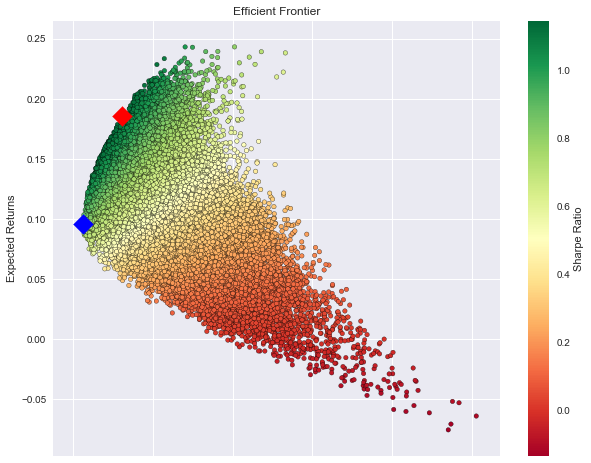

In [94]:
# plot our efficient frontier
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', cmap='RdYlGn', edgecolor='black', figsize=(10,8), grid=True)
plt.scatter(x=min_risk_port['Volatility'], y=min_risk_port['Returns'], c='blue', marker='D', s=200)
plt.scatter(x=sharpe_port['Volatility'], y=sharpe_port['Returns'], c='red', marker='D', s=200)
plt.xlabel('Volatility (Std. Dev.)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [16]:
print(min_risk_port.T)

                 21098
Returns       0.095710
Volatility    0.113708
Sharpe Ratio  0.841718
KO Weight     0.116966
PFE Weight    0.545062
AAPL Weight   0.319195
WTI Weight    0.008869
TSLA Weight   0.009908


In [17]:
print(sharpe_port.T)

                 38108
Returns       0.185331
Volatility    0.162064
Sharpe Ratio  1.143562
KO Weight     0.498679
PFE Weight    0.118605
AAPL Weight   0.236004
WTI Weight    0.146417
TSLA Weight   0.000294


In [32]:
print(sharpe_port['Returns'].item())

0.1853306436570629
